In [1]:
import numpy as np 
import pickle
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
train = pd.read_csv('sentiment_tweets3.csv')

In [3]:
train

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [4]:
train['Label'].unique()

array([0, 1], dtype=int64)

In [5]:
train.loc[train['Label']==0, 'Label'] = 'Happy'

In [6]:
train.loc[train['Label']==1, 'Label'] = 'Unhappy'

In [7]:
train

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,Happy
1,217,is reading manga http://plurk.com/p/mzp1e,Happy
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,Happy
3,288,@lapcat Need to send 'em to my accountant tomo...,Happy
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,Happy
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,Unhappy
10310,802310,What do you do when depression succumbs the br...,Unhappy
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,Unhappy
10312,802312,dont mistake a bad day with depression! everyo...,Unhappy


In [8]:
#pip install nltk

In [9]:
import os as _os
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import string 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jpinf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import urllib.request
from bs4 import BeautifulSoup
from html.parser import HTMLParser
    
import re 
 

In [11]:
def prep(review):
    
    # Remove HTML tags.
    review = BeautifulSoup(review,'html.parser').get_text()
    
    # remove punctuation
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # upper case
    review = review.upper()
    

     # Tokenize to each word.
    token = nltk.word_tokenize(review)
    
    # Stemming
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in token]
    
    return " ".join(review)
    

In [12]:
train['Text'] = train['Text'].apply(prep)

In [13]:
df_x=train['Text']
df_y=train['Label']

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.3, random_state=9)
print(x_train.shape)
print(x_test.shape)

(7219,)
(3095,)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

In [16]:
tv = TfidfVectorizer(
                    ngram_range = (1,3),
                    sublinear_tf = True,
                    max_features = 40000)

In [17]:
train_tv = tv.fit_transform(x_train)
test_tv = tv.transform(x_test)

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 

In [19]:
rf2= RandomForestClassifier(n_estimators=250, criterion='gini',  n_jobs = -1)
rf2.fit(train_tv, y_train)


RandomForestClassifier(n_estimators=250, n_jobs=-1)

In [20]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression()


logreg.fit(train_tv, y_train)

LogisticRegression()

In [21]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier()
classifier.fit(train_tv, y_train)

SGDClassifier()

In [22]:
eclf = VotingClassifier(estimators=[
     ('rf2', rf2), ('logreg', logreg)], voting='soft')
eclf.fit(train_tv, y_train)


VotingClassifier(estimators=[('rf2',
                              RandomForestClassifier(n_estimators=250,
                                                     n_jobs=-1)),
                             ('logreg', LogisticRegression())],
                 voting='soft')

In [23]:
eclf.score(train_tv, y_train) 

0.9976451031998892

In [24]:
from sklearn.metrics import accuracy_score
y_pred = eclf.predict(test_tv )
accuracy_score(y_pred,y_test)

0.9961227786752828

In [25]:
eclfs = VotingClassifier(estimators=[
       ('logreg', logreg),('classifier', classifier)], voting='hard')
eclfs.fit(train_tv, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression()),
                             ('classifier', SGDClassifier())])

In [26]:
eclfs.score(train_tv, y_train) 

0.9850394791522371

In [27]:
from sklearn.metrics import accuracy_score
y_pred = eclfs.predict(test_tv )
accuracy_score(y_pred,y_test)

0.9896607431340873

In [28]:
import sklearn.metrics

In [29]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Happy       0.99      1.00      0.99      2380
     Unhappy       1.00      0.96      0.98       715

    accuracy                           0.99      3095
   macro avg       0.99      0.98      0.99      3095
weighted avg       0.99      0.99      0.99      3095



In [30]:
y_pred = eclfs.predict(test_tv )
y_true=y_test


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[2380,    0],
       [  32,  683]], dtype=int64)

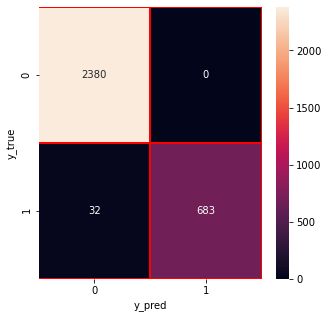

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
with open('tfid.pkl','wb') as f:
    pickle.dump(tv,f)

In [35]:
with open('Voting.pkl','wb') as f:
    pickle.dump(eclfs,f)

In [43]:
docs_new=[" fvck that depression"]
 
X_new_counts=tv.transform(docs_new)
#X_new_tfidf=tfidf_transformer.fit_transform(X_new_counts)
predicted=eclfs.predict(X_new_counts)
predicted[0]

'Happy'